In [1]:
from load import *
from torch import Tensor, nn
import torch
from model_base import *
from modules import *
from anim import *
import util
import matplotlib.pyplot as plt

ROOT = "./Datas/Week 8"

Q = 1.60217663e-19

In [2]:
sc = load_space_charge() * -Q
ep = load_elec_potential()

c:\Users\Darin\Documents\Repository\physical-simulation-ml-3900\week8.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


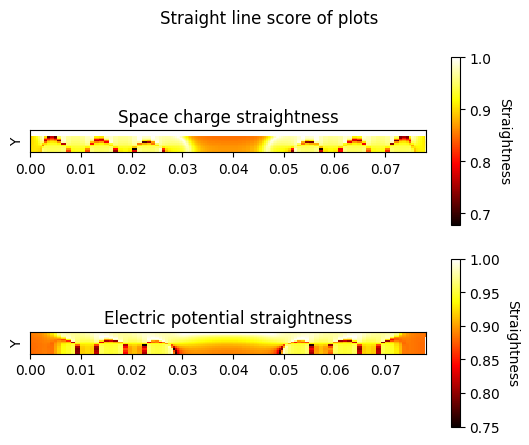

In [1]:
from week8 import plot_straightness
plot_straightness()